# Stability of least squares algorithms

We're going to explore several alternatives for least squares by means of the following fitting problem:

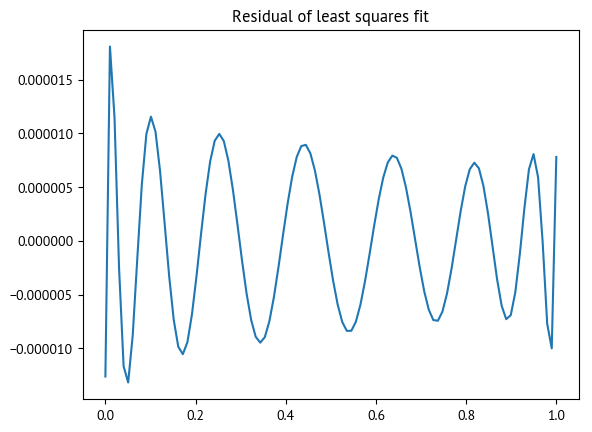

In [1]:
using PyPlot,LinearAlgebra

m = 100; n = 15;
t = (0:m-1)/(m-1);
A = [t[i].^(j-1) for i=1:m, j=1:n];
b = @. exp(sin(4*t));
x = A\b;

plot(t,b-A*x)
title("Residual of least squares fit");

You can see that the fit is quite good. As in the text, we will renormalize the vector $b$ to make the last coefficient of the solution equal to 1. (See the section at the end for more on this constant.) That allows us to easily assess the accuracy of the computed answers.

In [2]:
b = b/2006.787453104852;
x = A\b;  y = A*x;

As in the text, we compute all the numbers associated with the conditioning of the least squares problem, as described by Theorem 18.1. Since the residual is small, the conditioning of $x$ will be close to $\kappa(A)$.

In [3]:
@show κ = cond(A);
@show θ = asin(norm(y-b)/norm(b));
@show η = norm(A)*norm(x)/norm(y);

κ = cond(A) = 2.2717770364404953e10
θ = asin(norm(y - b) / norm(b)) = 3.746111014137631e-6
η = (norm(A) * norm(x)) / norm(y) = 237317.53935704296


In [4]:
K = zeros(2,2);
K[1,1] = sec(θ);  K[2,1] = κ*K[1,1];
K[1,2] = K[2,1]/η;  K[2,2] = κ + κ^2*tan(θ)/η;
K

2×2 Array{Float64,2}:
 1.0         95727.3       
 2.27178e10      3.08645e10

## Backslash

The internal backslash does Householder QR, including an extra column swapping ability to improve accuracy in some situations. Here's how it does.

In [5]:
x = A\b;
@show x[n]
@show errBS = abs(x[n]-1);

x[n] = 0.999999767734651
errBS = abs(x[n] - 1) = 2.3226534895393058e-7


We've lost about 9 digits of accuracy, which is in line with the conditioning of $x$ with respect to $A$ (the (2,2) element of $K$ above). 

## Householder QR solution

With a default call to `qr`, column pivoting is not used. Unless $A$ is nearly rank-deficient, this usually does not matter much.

In [6]:
Q,R = qr(A);
x = R\(Matrix(Q)'*b);
@show x[n]
@show errHH = abs(x[n]-1);

x[n] = 1.000000033319619
errHH = abs(x[n] - 1) = 3.331961906383185e-8


## Modified GS QR solution

Classical Gram-Schmidt is too unstable even to bother with. The modified form is better, but problems remain:

In [7]:
function mgs(A)
    m,n = size(A)
    Q = zeros(eltype(A),m,n)
    R = zeros(eltype(A),n,n)
    B = copy(A)
    for k = 1:n
        R[k,k] = norm(B[:,k])
        Q[:,k] = B[:,k]/R[k,k]
        for j = k+1:n
            R[k,j] = dot(Q[:,k],B[:,j])
        end
        B -= Q[:,k]*R[k,:]'
    end
    return Q,R
end  
Q,R = mgs(A);
x = R\(Q'*b);
@show x[n]
@show errMGS = abs(x[n]-1);

x[n] = 0.9699314169999176
errMGS = abs(x[n] - 1) = 0.030068583000082416


Crikey! That's much worse than is accounted for by the problem conditioning. The culprit is that $Q$ is far from orthogonal.

In [8]:
norm(Q'*Q-I)

3.857695813726171e-7

There's a surprisingly simple workaround. We can imitate Gaussian elimination and factor an "augmented matrix" in order to get what amounts to an implicit-Q result. This algorithm is provably backward stable.

In [9]:
Q,R = mgs([A b]);
x = R[1:n,1:n] \ R[1:n,n+1];
@show x[n]
@show errMGS = abs(x[n]-1);

x[n] = 0.9999999950035883
errMGS = abs(x[n] - 1) = 4.996411728797057e-9


On my machine, this is the best solution yet!

## Normal equations

This problem is a perfect storm for the normal equations: a very good fit (small residual) and a badly conditioned matrix. Squaring that condition number is catastrophic; the answer does not have even one correct digit.

In [10]:
x = (A'*A)\(A'*b);
@show x[n];

x[n] = 0.1669565586915432


## SVD

The SVD is considered the gold standard of stability in least squares. It is preferred to QR when the matrix is nearly or numerically rank deficient.

In [11]:
U,s,V = svd(A)
x = V*((U'*b)./s)
@show x[n]
@show errSVD = abs(x[n]-1);

x[n] = 0.9999997996767235
errSVD = abs(x[n] - 1) = 2.0032327652241833e-7


## Extended precision

If you compare my results to those in the text, you will find that they are different in some respects. For one thing, I use a different normalization constant for $b$. This constant is supposed to come from a higher-precision computation of the problem. 

There's some ambiguity here. Should all computations be evaluated in extended precision from the start of the fitting problem, or only once the data $A$ and $b$ have been formed in double precision? Here's the second interpretation.

In [12]:
setprecision(BigFloat,128);  # use 128-bit floats
b = convert( Array{BigFloat},@. exp(sin(4t)) );
A = convert(Array{BigFloat},A);
Q,R = qr(A);
x1 = R\ (Matrix(Q)'*b);
Q,R = mgs([A b]);
x2 = R[:,1:n] \ R[:,n+1];
x3 = (A'*A)\(A'*b);
x4 = A\b;

[x1[n],x2[n],x3[n],x4[n]]

4-element Array{BigFloat,1}:
 2.006787463323107345600525808241847734603e+03
 2.006787463323107345600525808248517301958e+03
 2.006787463323107345355821142689557555838e+03
 2.006787463323107345600525808229074541564e+03

You can see how the normal equation result wanders off on its own first, before the other ones start to disagree.

The above calculation used high precision for the problem *as stated in double precision*. That is, the problem was already perturbed at the 16th digit or so. If we solve the problem using extended precision from the start, then the result should be accurate to the true exact problem, up to the last 9 digits or so (or 20 digits for the normal equations). 

In [13]:
t = BigFloat.(collect(0:m-1))/BigFloat(m-1);
A = [t[i].^j for i=1:m, j=0:n-1];
b = @. exp(sin(4*t));

Q,R = qr(A);
x1 = R\ (Matrix(Q)'*b);
Q,R = mgs([A b]);
x2 = R[:,1:n] \ R[:,n+1];
x3 = (A'*A)\(A'*b);
x4 = A\b;

[x1[n],x2[n],x3[n],x4[n]]

4-element Array{BigFloat,1}:
 2.006787453104851833876103814338068195207e+03
 2.006787453104851833876103814355358078406e+03
 2.006787453104851834342923924263804001505e+03
 2.006787453104851833876103814376793404332e+03

In [14]:
Float64.(ans)

4-element Array{Float64,1}:
 2006.787453104852
 2006.787453104852
 2006.787453104852
 2006.787453104852

Unfortunately, neither of my results matches the T&B number of 2006.787453080206, which I can't explain. 